<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/Walmartsales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walmartsales_Forecasting

**Retail_Sales_Forecasting 분석 내용 추가 **

** 분석 개요 **

:월마트 매장 및 부서별 주간 매출을 예측하여 재고 관리 및 인력 배치 최적화 지원

데이터 출처: Kaggle [Walmart Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [ ]:
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [ ]:
# 데이터 조인
data = train.merge(stores, on='Store', how='left')
data = data.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

print(f"Data Shape: {data.shape}")
display(data.head(3))
display(data.info())

Data Shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


None

In [ ]:
# 날짜 변환
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

In [ ]:
# MarkDown 컬럼에 결측치 보완, 해당 주차에 프로모션이 없었음을 의미함으로 0으로 대체
data.fillna({'MarkDown1': 0, 'MarkDown2': 0, 'MarkDown3': 0, 'MarkDown4': 0, 'MarkDown5': 0}, inplace=True)

# 휴일 여부 True/False -> 1/0
data['IsHoliday'] = data['IsHoliday'].astype(int)

# 매장 타입 인코딩 기존 A, B, C -> 0, 1, 2
type_mapping = {'A': 0, 'B': 1, 'C': 2}
data['Type'] = data['Type'].map(type_mapping)


print(data.head())
print(data.isnull().sum().sum())



   Store  Dept       Date  Weekly_Sales  IsHoliday  Type    Size  Temperature  \
0      1     1 2010-02-05      24924.50          0     0  151315        42.31   
1      1     1 2010-02-12      46039.49          1     0  151315        38.51   
2      1     1 2010-02-19      41595.55          0     0  151315        39.93   
3      1     1 2010-02-26      19403.54          0     0  151315        46.63   
4      1     1 2010-03-05      21827.90          0     0  151315        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.548        0.0        0.0        0.0        0.0        0.0   
2       2.514        0.0        0.0        0.0        0.0        0.0   
3       2.561        0.0        0.0        0.0        0.0        0.0   
4       2.625        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  Year  Month  Week  
0  211.096358         8.106  20

**월별/주차별 매출 트렌드**

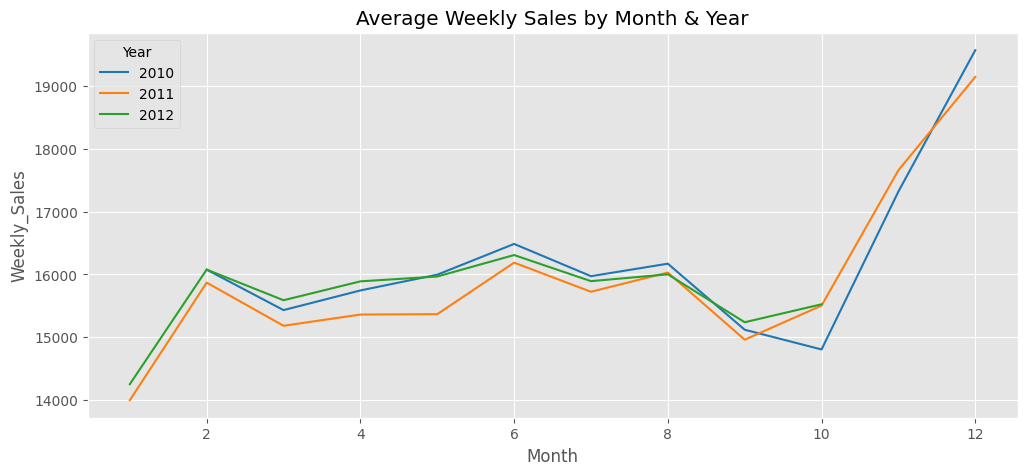

In [ ]:
# 불필요한 경고 메시지 숨김
warnings.filterwarnings('ignore')
# 그래프 스타일 설정
plt.style.use('ggplot')

# 월별 평균 매출 시각화
plt.figure(figsize=(12, 5))
monthly_sales = data.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()
sns.lineplot(x='Month', y='Weekly_Sales', hue='Year', data=monthly_sales, palette='tab10')
plt.title('Average Weekly Sales by Month & Year')
plt.show()

11월과 12월에 매출이 급격히 상승하는 패턴, 해마다 유사

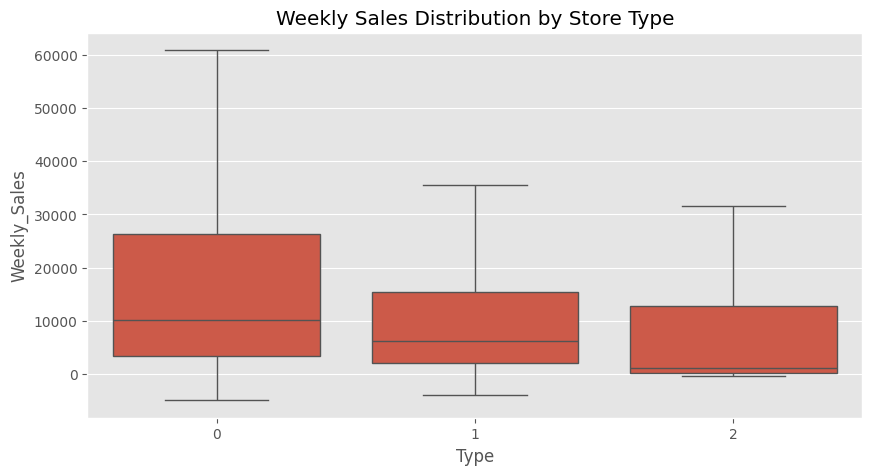

In [ ]:
# 매장 유형과 크기에 따른 매출
plt.figure(figsize=(10, 5))
sns.boxplot(x='Type', y='Weekly_Sales', data=data, showfliers=False)
plt.show()

타입A 매장의 매출 규모가 가장 크고 C가 가장 작음

In [ ]:
# 매장 크기와 매출의 상관관계
correlation = data[['Size', 'Weekly_Sales']].corr().iloc[0,1]
print(f"매장 크기와 매출의 상관계수: {correlation:.3f}")

매장 크기와 매출의 상관계수: 0.244


**휴일의 영향력 분석**

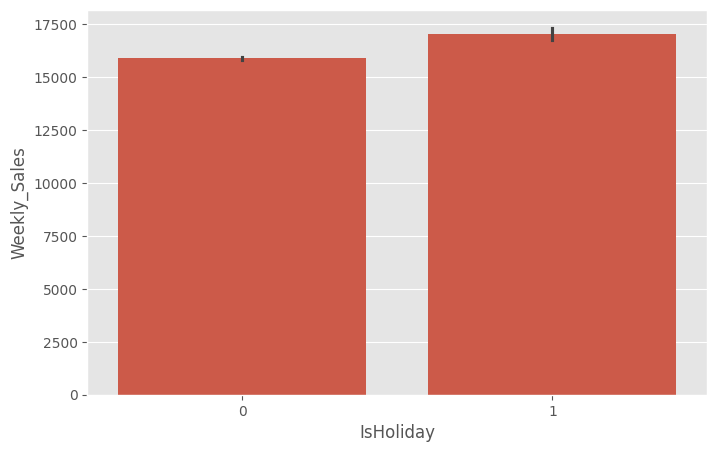

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.show()

휴일 주간의 매출이 평일보다 조금 더 많았음
하지만 특정 대목 휴일이 혼합되어 있어서 어떤 휴일인지 확인 필요

**머신러닝 모델링 (Random Forest Regressor)**
시계열 데이터이지만 시계열 모델 대신 Random Forest 선택

조합이 수천 개에 달해 개별 시계열 모델을 만드는 것보다 하나의 머신러닝 모델이 패턴을 학습하는 것이 효율적

온도, 연료비 등 외부 변수를 유연하게 반영하기 위해

In [ ]:
# 2010~2011년을 학습용, 2012년을 검증용으로 사용
train_set = data[data['Date'] < '2012-02-01']
val_set = data[data['Date'] >= '2012-02-01']

In [ ]:
# 불필요한 컬럼 제거
drop_cols = ['Date', 'Weekly_Sales']
X_train = train_set.drop(drop_cols, axis=1)
y_train = train_set['Weekly_Sales']
X_val = val_set.drop(drop_cols, axis=1)
y_val = val_set['Weekly_Sales']

In [ ]:
# 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=42)

In [ ]:
# 모델 예측
preds = rf_model.predict(X_val)

In [ ]:
# 2천불 정도의 매출 오차
mae = mean_absolute_error(y_val, preds)
#rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"MAE: {mae:.2f}")
#print(f"RMSE: {rmse:.2f}")

MAE: 2090.43


In [ ]:
from sklearn.metrics import r2_score

inf
9956573831.95
13.19452736756262
0.958185071388896


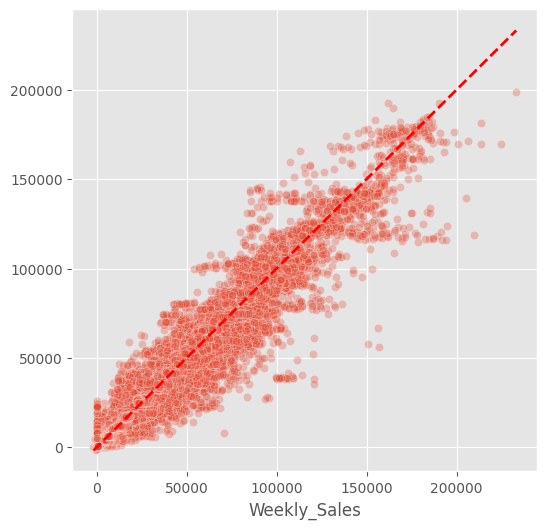

In [ ]:
# 얼마나 틀렸는지 확인하기 위한 MAPE 계산 및 보정
mape = np.mean(np.abs((y_val - preds) / y_val)) * 100
print(f"{mape:.2f}")
mape = np.mean(np.abs((y_val - preds) / (y_val + 1e-10))) * 100
print(f"{mape:.2f}")
wmape = np.sum(np.abs(y_val - preds)) / np.sum(np.abs(y_val)) * 100
print(wmape)

# 0.8 이상으로 매출 변동을 잘 설명
r2 = r2_score(y_val, preds)
print(r2)

# x축: 실제 매출, y축: 예측 매출
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_val, y=preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.show()

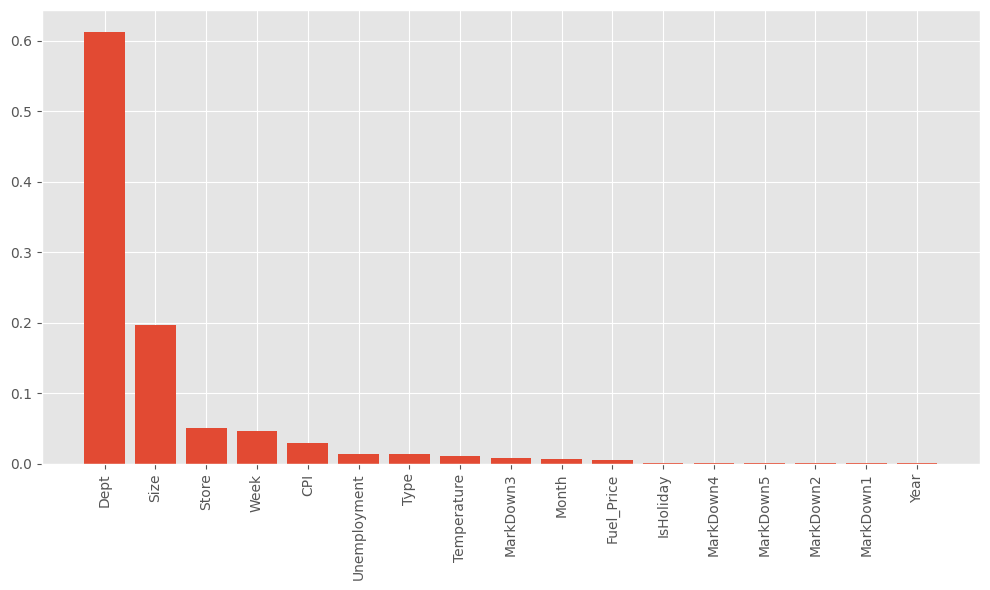

In [ ]:
# 변수 중요도 시각화
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), features_names[indices], rotation=90)
plt.tight_layout()
plt.show()

**결과 해석**

Dept: 매출 규모 가장 크게 영향

Size: 매장의 규모가 매출의 중요 요인

Week: 계절성을 반영하는 Week 변수가 상위권

외부 변수: CPI, Unemployment, Fuel_Price 등 거시 경제 지표는 상대적으로 중요도를 낮게 측정
이는 단기 매출 예측에서 시즌과 매장 특성이 경제 상황보다 더 즉각적인 영향을 미침

추가 분석: 시계열 특성 반영 추가 이전 주차의 매출이나 이동 평균을 변수로 추가하면서 최근 추세 확인